# **Service란?**

* Pod집합에서 실행중인 애플리케이션을 네트워크 서비스로 노출하는 추상화 방법을 서비스 라고 한다. 
* 쿠버네티스를 사용하면 익숙하지 않은 서비스 디스커버리 메커니즘을 사용하기 위해 애플리케이션을 수정할 필요가 없다. 
* 쿠버네티스는 파드에게 고유한 IP 주소와 파드 집합에 대한 단일 DNS 명을 부여하고, 그것들 간에 로드-밸런스를 수행할 수 있다.




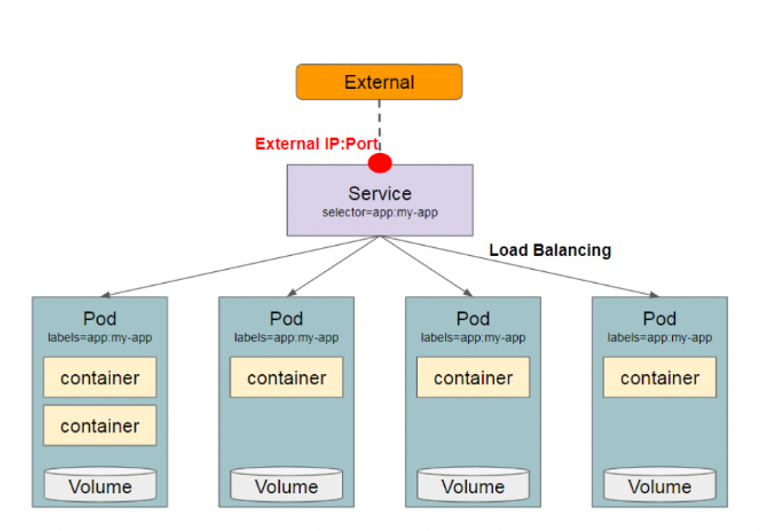

**Pod의 문제점**

* Pod는 일시적으로 생성한 컨테이너의 집합
* Pod가 지속적으로 생겨났을 때 서비스하기 적합하지 않음
* Pod의 생성, 삭제, 이전 등에 따른 관리의 어려움
* Pod는 IP 주소가 변동되기 때문에 로드밸런싱을 관리해줄 또 다른 리소스가 필요


**서비스의 필요성**

* 동적으로 변하는 pod에게 고정된 방법으로 접근가능

* 외부에서 서비스를 거쳐서 pod에게 접근가능(ingress대신)

* pod가 옮겨겨갔을 때 서비스는 자동으로 새로뜬 pod를 바라보기 떄문에실제 접속하는 사용자는 서비스만 바라보고 있으면 댐

**서비스의 구성**

* 여러개의 pod와 Volume을 이용해서 컨테이너 정의한 후 여러개의 pod를 서비스할 때, 로드밸런서를 이용해서 하나의 ip와포트로 묶어서 하나의 서비스로 제공

**서비스의 특징**

**Label Selector에서 특정 라벨을 가진 pod만 가지고 서비스로 묶음**

- Label Selector (라벨 셀렉터): ip가 바뀌는 pod들을 어떤 Service로 묶을지 정의하는 이름
- Label(라벨) : ip가 바뀌는 pod들을 부를 이름 (각 pod를 생성할때 opbject Spec의 metadata 부분에서 정의)

**Label Selector와 Label을 사용하는 이유**

* Pod의 경우 동적생성 -> 장애가발생 -> 자동 Pod restart -> ip가 바뀜

* pod의 목록을 지정할때 ip입력하는 게 불가능

* Label Selector (라벨 셀렉터)와 Label(라벨)지정

* 라벨셀렉터에서 특정 라벨을 가진 pod만 선택해서 Service에 묶는다

# **서비스의 종류**

**ClusterIP**

* **ClusterIP**는 **파드들이 클러스터 내부의 다른 리소스들과 통신**할 수 있도록 해주는 가상의 클러스터 전용 IP.
* 이 유형의 서비스는 `<ClusterIP>`로 들어온 클러스터 내부 트래픽을 해당 파드의 `<파드IP>:<targetPort>`로 넘겨주도록 동작하므로, **오직 클러스터 내부에서만 접근 가능**하게 된다.
* 쿠버네티스가 지원하는 기본적인 형태의 서비스다.

### **Selector를 포함하는 형태**

TCP 포트 `9376`을 수신 대기(listen)하며 `app=myapp, type=frontend`라는 레이블을 공유하는 파드들에게 `myapp-service`라는 이름으로 접근할 수 있게 해주는 `ClusterIP` 유형의 서비스를 정의하면 다음과 같다.

```
apiVersion: v1
kind: Service
metadata:
  name: go-clusterip-service
  namespace: default
spec:
  selector:
    app: go-gin
  type: ClusterIP
  sessionAffinity: None
  sessionAffinityConfig:
    clientIP:
      timeoutSeconds: 10800
  ports:
    - name: go-clusterip-service
      protocol: TCP
      port: 80
      targetPort: 8080
```

* `spec.selector`에서 지정된 레이블로 여러 파드들이 존재할 경우, 서비스는 그 파드들을 외부 요청(request)을 전달할 엔드포인트(endpoints)로 선택하여 트래픽을 분배하게 된다.
* 이를 이용 한 노드 안에 여러 파드, 또는 여러 노드에 걸쳐 있는 여러 파드에 동일한 서비스를 적용할 수 있다.

* 여러 포트들의 연결이 필요할 때도 있다. *(예: HTTP/HTTPS)* 이럴 땐 `spec.ports`에 리스트 형태로 `name` 값을 부여하여 각각 추가해주면 된다.
* 이때 `name` 필드에 들어가는 값은 반드시 **영문/소문자 및 숫자와 `-`**로만 이루어져야 하며, 첫 글자와 마지막 글자는 반드시 **영문/소문자 및 숫자**로만 쓰여야 한다.

```
apiVersion: v1
kind: Service
metadata:
  name: myapp-service
spec:
  type: ClusterIP
  ports:
  - name: http
    protocol: TCP
    targetPort: 9376
    port: 80
  - name: https
    protocol: TCP
    targetPort: 9377
    port: 443
  selector:
    app: myapp
    type: frontend

```

### **Selector가 제외된 형태**

* 필요에 따라 엔드포인트(Endpoints)를 수동으로 직접 지정해줘야 할 때가 있다.
* 테스트 환경과 상용 환경의 설정이 서로 다르거나, 다른 네임스페이스 또는 클러스터에 존재하는 파드와의 네트워크를 위해 서비스-서비스 간의 연결을 만들어야 하는 상황 등이 있다.

* 이런 경우 `spec.selector` 없이 서비스를 만들고, 해당 서비스가 가리킬 엔드포인트(Endpoints) 객체를 직접 만들어 해당 서비스에 맵핑하는 방법이 있다.

```
apiVersion: v1
kind: Service
metadata:
  name: myapp-service
spec:
  ports:
    - protocol: TCP
      port: 80
      targetPort: 9376

```

```
apiVersion: v1
kind: Endpoints
metadata:
  name: myapp-service		# 연결할 서비스와 동일한 name을 메타데이터로 입력
subsets:					# 해당 서비스로 가리킬 endpoint를 명시
  - addresses:
      - ip: 192.0.2.42
    ports:
      - port: 9376

```

* 주의해야 할 점은, 엔드포인트로 명시할 IP는 loopback(`127.0.0.0/8`) 또는 link-local(`169.254.0.0/16, 224.0.0.0/24`) 이어서는 안 된다

**NodePort**

* 노드포트는 모든 워커들의 특정 포트를 이용하여 접근하도록 설정하는 타입이다.
* Pod가 탑재된 Node에 접근할 수 있는 포트를 외부로 노출시킨다.
* 포트당 하나의 서비스를 사용하며 30000~32767 사이의 포트를 사용한다.
* 노드포트 또한 클러스터 아이피가 있으며, 쿠버네티스 클러스터의 모든 노드에 똑같은 포트가 할당된다.


```yaml
apiVersion: v1
kind: Service
metadata:
  name: go-gin-nodeport
  labels:
    run: go-gin-nodeport
spec:
  type: NodePort     # 서비스 타입
  ports:
  - port: 80       # 서비스 포트
    targetPort: 8080   # 타켓, 즉 pod의 포트
    protocol: TCP
    name: http
  selector:
    app: go-gin
```

**nodeport 포트포워딩 하기**

```yaml
kubectl port-forward services/go-gin-nodeport 8081:80 -n default
```


**LoadBalancer**

* **Nodeport 타입을 확장시켜 실질적으로 서비스를 외부에 노출할 수 있는 서비스로 Node에 트래픽을 분산시켜주는 역할이다.** 
* Load Balancer는 쿠버네티스에서 자동으로 생성되지 않아서 IP를 할당해주는 plugin이 설치되어 있어야한다. 
* AWS, GCP, Azure 등의 쿠버네티스 플랫폼을 사용할 경우 외부 IP를 지원해주는 플러그인이 설치되어있어 Load Balancer 타입의 서비스를 생성할 경우 외부에서 접속할 IP를 알아서 만들어준다.


```yaml
apiVersion: v1
kind: Service
metadata:
  name: go-gin-service
spec:
  type: LoadBalancer
  selector:
    app: go-gin
  ports:
    - name: http
      port: 80
      targetPort: 8080
```


**ExternalName**


* 서비스에 selector 대신 DNS name을 직접 명시하고자 할 때에 쓰인다.
* `spec.externalName`항목에 필요한 DNS 주소를 기입하면, 클러스터의 DNS 서비스가 해당 주소에 대한 `CNAME` 레코드를 반환하게 된다.